In [12]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset

# Step 1: Generate Lorenz System Data
def lorenz_system(state, t, sigma=10, rho=28, beta=8/3):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

# Generate data using odeint
np.random.seed(0)
t = np.linspace(0, 30, 10000)  # Time vector
initial_state = [1.0, 1.0, 1.0]
lorenz_data = odeint(lorenz_system, initial_state, t)
x_data = lorenz_data[:, 0]
y_data = lorenz_data[:, 1]
z_data = lorenz_data[:, 2]

# Step 2: Data Preparation
sequence_length = 60
prediction_length = 10
train_data = lorenz_data[:-500]  # Use most of the data for training
val_data = lorenz_data[-500:]    # Use the last 500 points for validation

# Normalize data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data = scaler.fit_transform(train_data)
val_data = scaler.transform(val_data)


In [13]:

# Custom Dataset Class
class LorenzDataset(Dataset):
    def __init__(self, data, sequence_length, prediction_length):
        self.data = data
        self.sequence_length = sequence_length
        self.prediction_length = prediction_length

    def __len__(self):
        return len(self.data) - self.sequence_length - self.prediction_length + 1

    def __getitem__(self, idx):
        return (
            torch.tensor(self.data[idx:idx + self.sequence_length], dtype=torch.float32),
            torch.tensor(self.data[idx + self.sequence_length:idx + self.sequence_length + self.prediction_length], dtype=torch.float32),
        )

train_dataset = LorenzDataset(train_data, sequence_length, prediction_length)
val_dataset = LorenzDataset(val_data, sequence_length, prediction_length)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [14]:
# Step 3: Define the RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_size=3, hidden_size=8, num_layers=1):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 3)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Only use the output at the last time step
        return out


class AutoRegressiveRNN(nn.Module):
    def __init__(self, input_size=3, hidden_size=8, num_layers=1, forecast_length=prediction_length):
        super(AutoRegressiveRNN, self).__init__()
        self.forecast_length = forecast_length
        self.rnn = RNNModel(input_size, hidden_size, num_layers)

    def forward(self, x_next):
        outputs = []
        #for _ in range(self.forecast_length):
        #    pred = self.rnn(x_next)
        #    x_next = torch.cat([x_next[:, 1:, :], pred.unsqueeze(1)], axis=1)
        #    outputs.append(pred)
        #return torch.stack(outputs, 1)
        seq_len = x_next.shape[1]
        for _ in range(seq_len + self.forecast_length):
            pred = self.rnn(x_next)
            x_next = torch.cat([x_next[:, 1:, :], pred.unsqueeze(1)], axis=1)
            outputs.append(pred)
        return torch.stack(outputs[-self.forecast_length:], 1)


# Step 4: Define the MLP Model
class MLPModel(nn.Module):
    def __init__(self, input_size=3*sequence_length, hidden_size=8):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x.view(-1, 1, 3)


class AutoRegressiveMLP(nn.Module):
    def __init__(self, input_size=3*sequence_length, hidden_size=8, forecast_length=prediction_length):
        super(AutoRegressiveMLP, self).__init__()
        self.forecast_length = forecast_length
        self.mlp = MLPModel(input_size, hidden_size)

    def forward(self, x_next):
        outputs = []
        for _ in range(self.forecast_length):
            pred = self.mlp(x_next)
            x_next = torch.cat([x_next[:, 1:, :], pred], axis=1)
            outputs.append(pred.squeeze(1))
        return torch.stack(outputs, 1)

In [15]:

# Step 5: Train and Compare the Models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

rnn_model = AutoRegressiveRNN().to(device)
mlp_model = AutoRegressiveMLP().to(device)

loss_fn = nn.MSELoss()
rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)
mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)


In [16]:

# Training Loop
def train_model(model, optimizer, train_loader, val_loader, n_epochs=10):
    model.train()
    all_train_loss = []
    all_val_loss = []
    for epoch in range(n_epochs):
        train_loss = 0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            # Forward pass
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        all_train_loss.append(train_loss / len(train_loader))
        
        # Validation after each epoch
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                y_pred = model(x_val)
                val_loss += loss_fn(y_pred, y_val).item()
        val_loss /= len(val_loader)
        all_val_loss.append(val_loss)
        print(f"Epoch [{epoch+1}/{n_epochs}], Val Loss: {val_loss:.4f}")
        model.train()
    return pd.DataFrame({
        'train_loss': all_train_loss, 
        'val_loss': all_val_loss
    })

print("Training RNN...")
rnn_loss_df = train_model(rnn_model, rnn_optimizer, train_loader, val_loader)

print("Training MLP...")
mlp_loss_df = train_model(mlp_model, mlp_optimizer, train_loader, val_loader)

Training RNN...
Epoch [1/10], Val Loss: 0.1143
Epoch [2/10], Val Loss: 0.1193
Epoch [3/10], Val Loss: 0.1125
Epoch [4/10], Val Loss: 0.1138
Epoch [5/10], Val Loss: 0.1160
Epoch [6/10], Val Loss: 0.1288
Epoch [7/10], Val Loss: 0.1196
Epoch [8/10], Val Loss: 0.1188
Epoch [9/10], Val Loss: 0.1157
Epoch [10/10], Val Loss: 0.1146
Training MLP...
Epoch [1/10], Val Loss: 0.0007
Epoch [2/10], Val Loss: 0.0006
Epoch [3/10], Val Loss: 0.0005
Epoch [4/10], Val Loss: 0.0003
Epoch [5/10], Val Loss: 0.0003
Epoch [6/10], Val Loss: 0.0004
Epoch [7/10], Val Loss: 0.0002
Epoch [8/10], Val Loss: 0.0002
Epoch [9/10], Val Loss: 0.0002
Epoch [10/10], Val Loss: 0.0002


[]

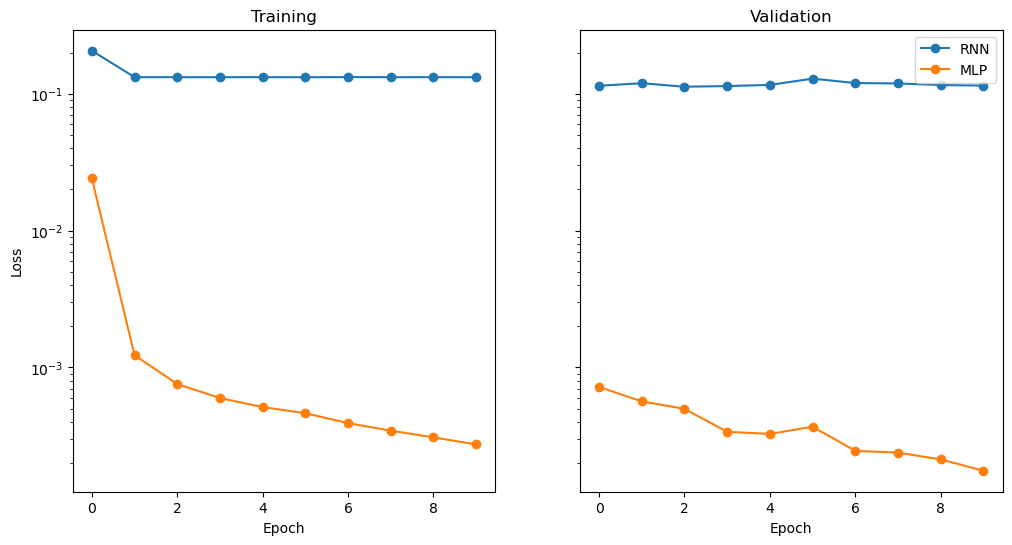

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

rnn_loss_df['train_loss'].plot(ax=axes[0], title='Training', marker='o')
mlp_loss_df['train_loss'].plot(ax=axes[0], title='Training', marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')

rnn_loss_df['val_loss'].plot(ax=axes[1], title='Validation', marker='o')
mlp_loss_df['val_loss'].plot(ax=axes[1], title='Validation', marker='o')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')

axes[1].legend(['RNN', 'MLP'])
axes[0].semilogy()
axes[1].semilogy()


In [18]:
def generate_forecasts(model, dataloader):
    model.eval()
    forecasts = []
    with torch.no_grad():
        for x_batch, _ in dataloader:
            x_batch = x_batch.to(device)
            pred = model(x_batch)
            forecasts.append(pred)
    return torch.cat(forecasts).cpu().numpy()

In [19]:
val_forecasts = []
for x_val, y_val in val_loader:
    val_forecasts.append(y_val)
val_ground_truth = torch.cat(val_forecasts).numpy()
rnn_forecasts = generate_forecasts(rnn_model, val_loader)
mlp_forecasts = generate_forecasts(mlp_model, val_loader)
rnn_forecasts.shape

(431, 10, 3)

In [20]:
val_ground_truth.shape

(431, 10, 3)

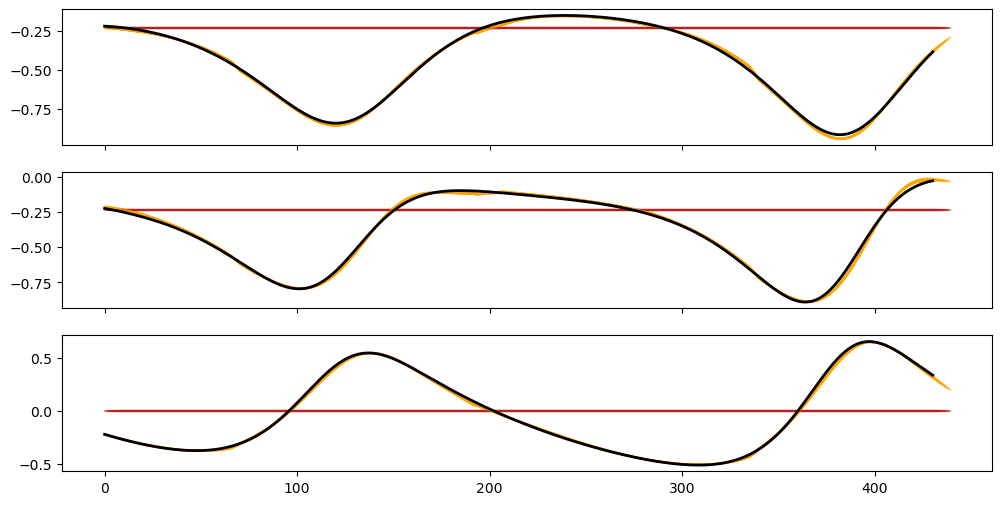

In [21]:
fig, axes = plt.subplots(3, 1, figsize=(12, 6), sharex=True)

for t in range(len(val_ground_truth)):
    x_range = list(range(t, t + prediction_length))
    axes[0].plot(x_range, rnn_forecasts[t, :, 0], color='firebrick', alpha=0.5)
    axes[1].plot(x_range, rnn_forecasts[t, :, 1], color='firebrick', alpha=0.5)
    axes[2].plot(x_range, rnn_forecasts[t, :, 2], color='firebrick', alpha=0.5)

    axes[0].plot(x_range, mlp_forecasts[t, :, 0], color='orange', alpha=0.5)
    axes[1].plot(x_range, mlp_forecasts[t, :, 1], color='orange', alpha=0.5)
    axes[2].plot(x_range, mlp_forecasts[t, :, 2], color='orange', alpha=0.5)



axes[0].plot(val_ground_truth[:, 0, 0], color='black', alpha=1, linewidth=2)
axes[1].plot(val_ground_truth[:, 0, 1], color='black', alpha=1, linewidth=2)
axes[2].plot(val_ground_truth[:, 0, 2], color='black', alpha=1, linewidth=2)

In [11]:
rnn_err = np.mean((rnn_forecasts - val_ground_truth) ** 2, axis=(0))

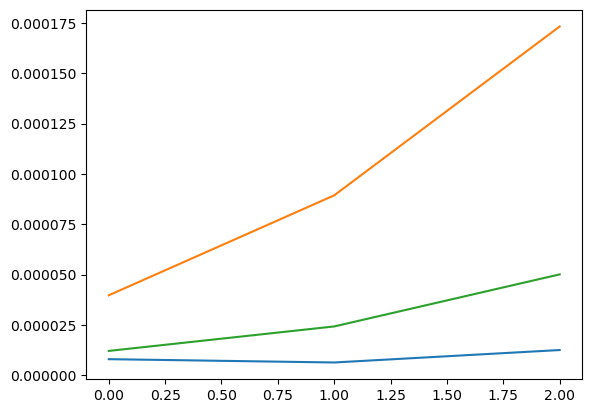

In [78]:
plt.plot(rnn_err[:, 0], label='RNN x')
plt.plot(rnn_err[:, 1], label='RNN x')
plt.plot(rnn_err[:, 2], label='RNN x')